# Notebook 1: Reproduce RGCN Model with APIs

This notebook demonstrates how to use GraphStorm's APIs to create graph machine learning pipelines. This notebooks are designed to run on GraphStorm's Standalone mode, i.e., in a single Linux machine with CPUs and GPUs. 

In this notebook, we willl reproduce the GraphStorm RGCN model with the nessessary APIs and use it to conduct a node classification task on the ACM dataset. By playing with this notebook, users will be able to get familiar with these APIs.

### Prerequsites

- GraphStorm installed using pip. Please find [more details on installation of GraphStorm](https://graphstorm.readthedocs.io/en/latest/install/env-setup.html#setup-graphstorm-with-pip-packages).
- ACM data created in the [Notebook 0: Data Prepare](https://graphstorm.readthedocs.io/en/latest/notebooks/Notebook_0_Data_Prepare.html), and is stored in the `./acm_gs_1p/` folder.
- Installation of supporting libraries, e.g., matplotlib.

In [1]:
# Setup log level in Jupyter Notebook
import logging
logging.basicConfig(level=20)

---

### 0. Initialize the GraphStorm Standalone Environment

We might set default argument values in `gs.initialize()` for the Standalone mode.

In [2]:
import graphstorm as gs
gs.initialize()

### 1. Setup GraphStorm Dataset and DataLoaders

The role of `gs.dataset.GSgnnData` is mainly for loading and storing given partitioned graphs. The existing roles such as target node type, label field, and node feature for training/inference, will move to Dataloader classes. 

In [3]:
# create a GraphStorm Dataset for the ACM graph data generated in the Notebook 0
acm_data = gs.dataloading.GSgnnData(part_config='./acm_gs_1p/acm.json')

`Dataloaders` take node feature dictionary and label field string. They do not handle features and labels, but pass these information to `Datasets`. And then `Datasets` retrieve related information and return to `Dataloaders`.

In [4]:
# define dataloaders for training and validation
nfeats_4_modeling = {'author':['feat'], 'paper':['feat'],'subject':['feat']}

train_dataloader = gs.dataloading.GSgnnNodeDataLoader(
    dataset=acm_data,
    target_idx=acm_data.get_node_train_set(ntypes=['paper']),
    node_feats=nfeats_4_modeling,
    label_field='label',
    fanout=[20, 20],
    batch_size=64,
    train_task=True)
val_dataloader = gs.dataloading.GSgnnNodeDataLoader(
    dataset=acm_data,
    target_idx=acm_data.get_node_val_set(ntypes=['paper']),
    node_feats=nfeats_4_modeling,
    label_field='label',
    fanout=[100, 100],
    batch_size=256,
    train_task=False)
test_dataloader = gs.dataloading.GSgnnNodeDataLoader(
    dataset=acm_data,
    target_idx=acm_data.get_node_test_set(ntypes=['paper']),
    node_feats=nfeats_4_modeling,
    label_field='label',
    fanout=[100, 100],
    batch_size=256,
    train_task=False)

INFO:root:part 0, train 9999
INFO:root:part 0, val 1249
INFO:root:part 0, test 1249


### 2. Create a GraphStorm-compatible RGCN Model for Node Classification 

This `Model` could be a customized model extends from `GSgnnModel` and implements required methods. The `GSgnnModel` has a few new API features.

In [5]:
# import a simplified RGCN model for node classification
from demo_models import RgcnNCModel

model = RgcnNCModel(
    g=acm_data.g,
    num_hid_layers=2,
    feat_size=gs.get_node_feat_size(acm_data.g, nfeats_4_modeling),
    hid_size=128,
    num_classes=14)

### 3. Setup a GraphStorm Evaluator

Now, `Evaluators` are task-oriented, i.e., `ClassificationEvaluator`, `RegressionEvaluator`, and `LPEvaluator`. And each Evaluator constructor could have a default evaluation metrics, i.e., `accuracy` for classification, `mse` for regression, and `mrr` for link prediction.

In [6]:
# setup a Classification evaluator for the trainer
evaluator = gs.eval.GSgnnClassificationEvaluator(eval_frequency=100)

### 4. Setup a Trainer and Training

In [7]:
# create a GraphStorm node task trainer for the RGCN model
trainer = gs.trainer.GSgnnNodePredictionTrainer(model)
trainer.setup_evaluator(evaluator)
trainer.setup_device(gs.utils.get_device())

In [8]:
# Train the model with the trainer using fit() function
trainer.fit(train_loader=train_dataloader,
            val_loader=val_dataloader,
            test_loader=test_dataloader,
            num_epochs=5,
            save_model_path='a_save_path/')

/home/ubuntu/anaconda3/envs/gsf/lib/python3.9/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (
INFO:root:Part 0 | Epoch 00000 | Batch 000 | Loss: 2.6409 | Time: 0.1613
INFO:root:Part 0 | Epoch 00000 | Batch 020 | Loss: 1.5550 | Time: 0.0373
INFO:root:Part 0 | Epoch 00000 | Batch 040 | Loss: 1.6473 | Time: 0.0351
INFO:root:Part 0 | Epoch 00000 | Batch 060 | Loss: 1.3423 | Time: 0.0381
INFO:root:Part 0 | Epoch 00000 | Batch 080 | Loss: 1.5958 | Time: 0.0290
INFO:root:Step 100 | Train loss: 1.4334
INFO:root:Step 100 | Validation accuracy: 0.5028
INFO:root:Step 100 | Test accuracy: 0.4804
INFO:root:Step 100 | Best Validation accuracy: 0.5028
INFO:root:Step 10

### (Optional) 5. Visualize Model Performance History

Next, we examine the model performance on the validation, and testing over the training process.

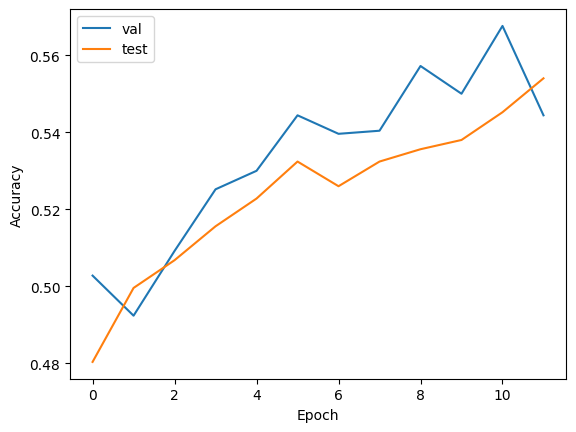

In [9]:
import matplotlib.pyplot as plt

# extract evaluation history of metrics from the trainer's evaluator:
val_metrics, test_metrics = [], []
for val_metric, test_metric in trainer.evaluator.history:
    val_metrics.append(val_metric['accuracy'])
    test_metrics.append(test_metric['accuracy'])

# plot the performance curves
fig, ax = plt.subplots()
ax.plot(val_metrics, label='val')
ax.plot(test_metrics, label='test')
ax.set(xlabel='Epoch', ylabel='Accuracy')
ax.legend(loc='best')

### 6. Inference with the Trained Model

GraphStorm automatically save the best performaned model in the given `save_model_path` argument. We can first find out what is the best model and its path.

In [10]:
# after training, the best model is saved to disk:
best_model_path = trainer.get_best_model_path()
print('Best model path:', best_model_path)

Best model path: a_save_path/epoch-3


In [11]:
# we can restore the model from the saved path using the model's restore_model() function.
model.restore_model(best_model_path)

INFO:root:successfully load the model from a_save_path/epoch-3
INFO:root:Time on load model: 0.005 seconds


In [12]:
# Setup dataloader for inference
infer_dataloader = gs.dataloading.GSgnnNodeDataLoader(dataset=acm_data,
                                                      target_idx=acm_data.get_node_test_set(ntypes=['paper']),
                                                      node_feats=nfeats_4_modeling,
                                                      label_field='label',
                                                      fanout=[100, 100],
                                                      batch_size=256,
                                                      train_task=False)
# Create an Inferrer object
infer = gs.inference.GSgnnNodePredictionInferrer(model)

INFO:root:part 0, test 1249


In [13]:
# Run inference on the inference dataset
infer.infer(infer_dataloader,
            save_embed_path='infer/embeddings',
            save_prediction_path='infer/predictions',
            use_mini_batch_infer=True)

INFO:root:save embeddings pf paper to infer/embeddings
INFO:root:Writing GNN embeddings to infer/embeddings in pytorch format.


In [14]:
# The GNN embeddings and predictions on the inference graph are saved to the folder named after the target_ntype
!ls -lh infer/embeddings/paper
!ls -lh infer/predictions/paper

total 640K
-rw-rw-r-- 1 ubuntu ubuntu 626K May  8 05:17 embed-00000.pt
-rw-rw-r-- 1 ubuntu ubuntu  11K May  8 05:17 embed_nids-00000.pt
total 84K
-rw-rw-r-- 1 ubuntu ubuntu 70K May  8 05:17 predict-00000.pt
-rw-rw-r-- 1 ubuntu ubuntu 11K May  8 05:17 predict_nids-00000.pt
